# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import pandas as pd
import random

import numpy as np
from numpy.random import (
    default_rng,
    uniform
)
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    ParameterSampler,
    RandomizedSearchCV
)
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos 

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
df = pd.read_csv("./data/loan_data.csv", comment="#")

## Curación de datos

## Análisis de correlaciones entre las variables

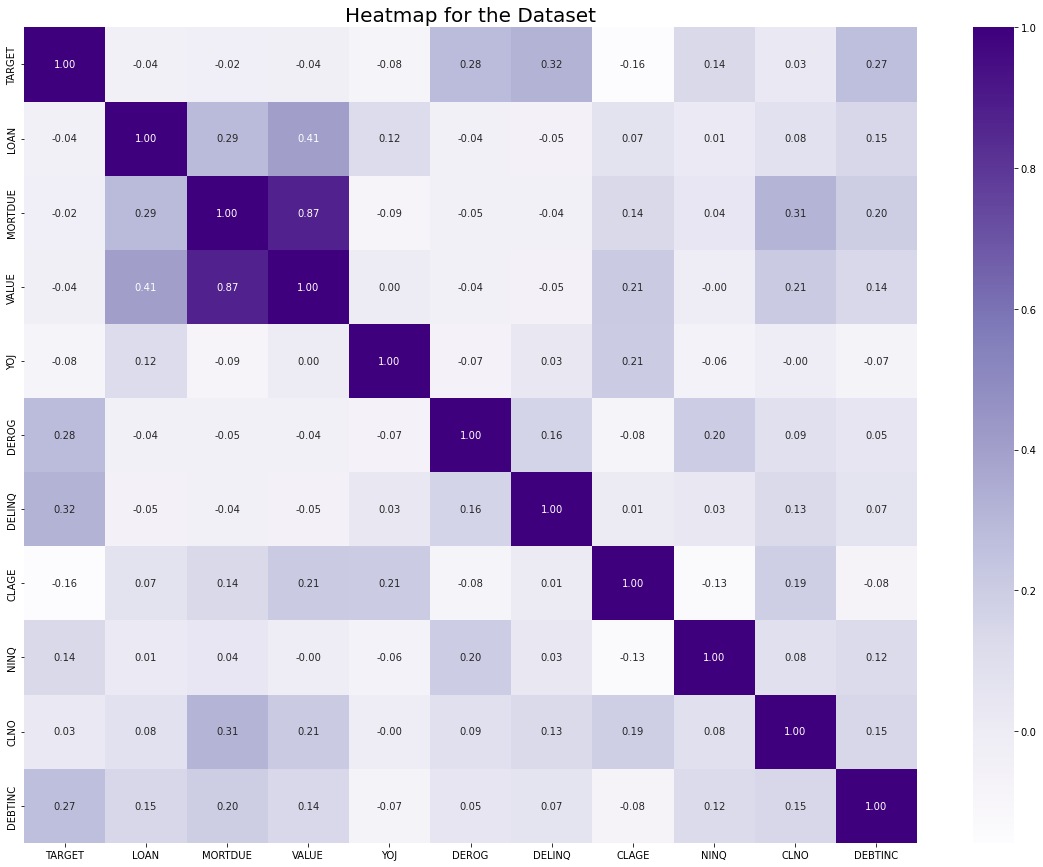

In [3]:
plt.rcParams['figure.figsize'] = (20, 15)
sns.heatmap(df.corr(), annot = True, fmt = ".2f", cmap = 'Purples')
plt.title('Heatmap for the Dataset', fontsize = 20)
plt.show()

#### Al tener muy pocas variables no creemos que sea beneficioso para el análisis deshacernos de alguna de ellas. Además, observamos que muy pocas variables impactan significamente a la variable TARGET, en un porcentaje entre el 14% y el 32%.

In [4]:
columns_list = df.columns

In [5]:
def histplot_graficos(data_frame, columns_list):
    n=0
    fig, axes = plt.subplots(nrows=len(columns_list), figsize=(20, 60))
    for i in columns_list:
        sns.histplot(data_frame[i], ax=axes[n], color='gray')
        n+=1

## Mostramos la distribución de los valores de las variables

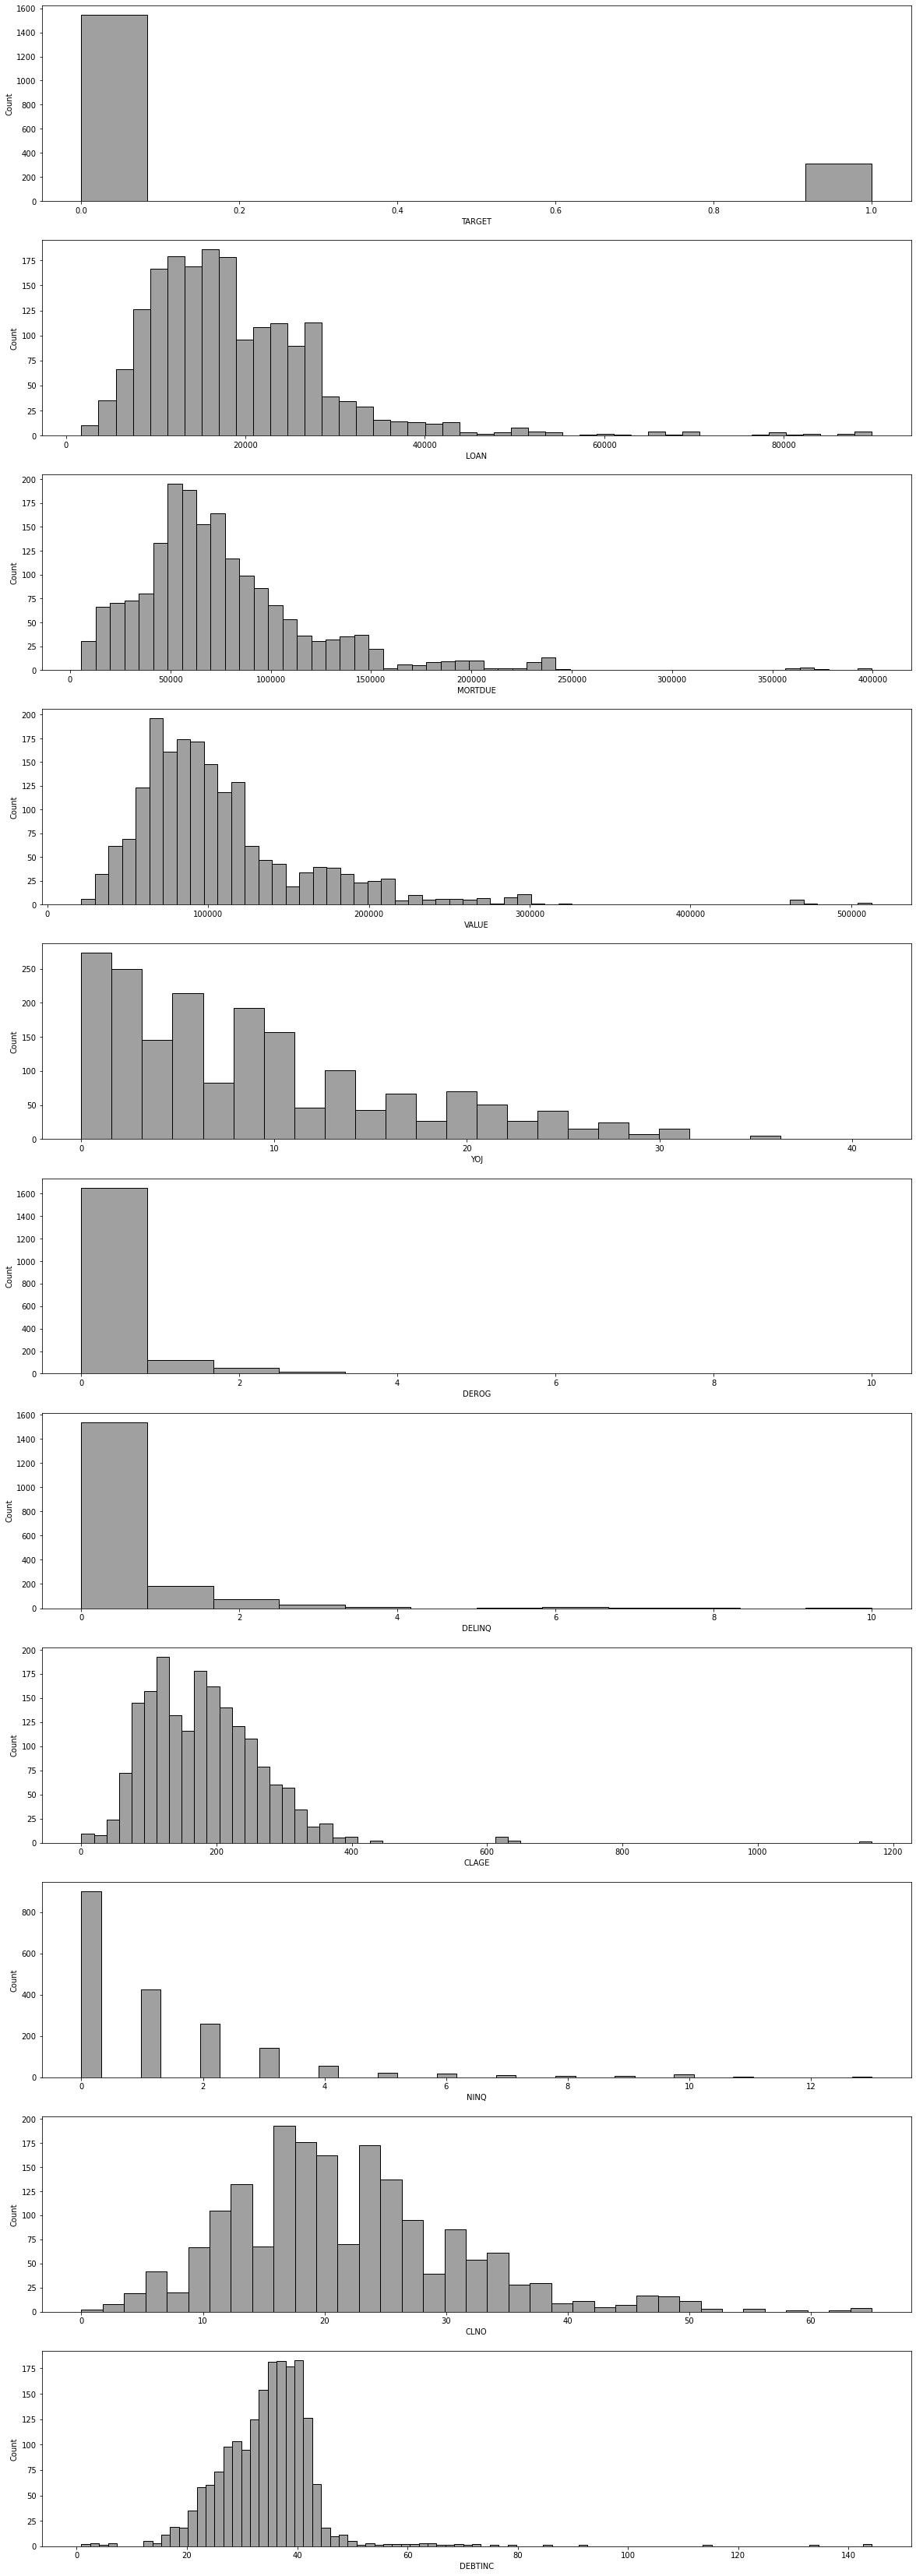

In [6]:
histplot_graficos(df, columns_list)

#### Observando las distribuciones de las variables, encontramos interesante visualizar los outliers de la columna DEBTINC a través de un boxplot

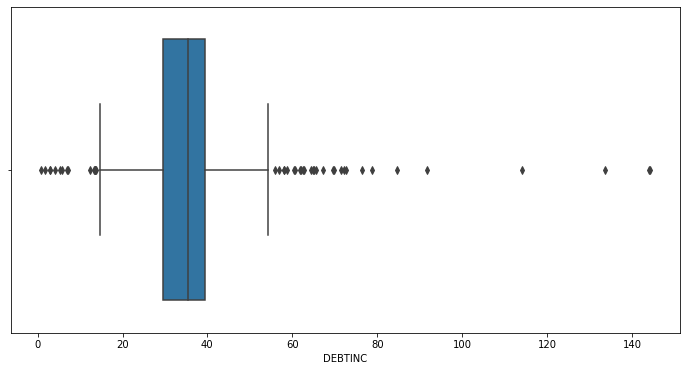

In [7]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(x=df["DEBTINC"]);

In [8]:
df["DEBTINC"]

0        29.209023
1        31.545694
2        41.210012
3        28.602076
4        30.686106
           ...    
1849     34.558417
1850     44.945929
1851     41.646731
1852    144.189001
1853     40.929793
Name: DEBTINC, Length: 1854, dtype: float64

#### Decidimos eliminar los outliers que están por encima del percentil 0.95 y aquéllos, por debajo del 0.05.

In [9]:
df_debtinc_qualite_95 = df["DEBTINC"].quantile(0.95)
df_debtinc_filtered = df[df["DEBTINC"] < df_debtinc_qualite_95]
df_debtinc_filtered

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1845,1,44400,67272.0,130818.0,9.0,0.0,0.0,112.591851,0.0,12.0,43.680965
1847,1,50200,197770.0,271676.0,16.0,0.0,0.0,146.862541,1.0,20.0,42.926580
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731


In [10]:
df_debtinc_quantile_5 = df_debtinc_filtered["DEBTINC"].quantile(0.05)
df_debtinc_filtered = df_debtinc_filtered[df_debtinc_filtered["DEBTINC"] > df_debtinc_quantile_5]
df_debtinc_filtered

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1845,1,44400,67272.0,130818.0,9.0,0.0,0.0,112.591851,0.0,12.0,43.680965
1847,1,50200,197770.0,271676.0,16.0,0.0,0.0,146.862541,1.0,20.0,42.926580
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731


### Decidimos visualizar los outliers de la columna LOAN a través de un boxplot.

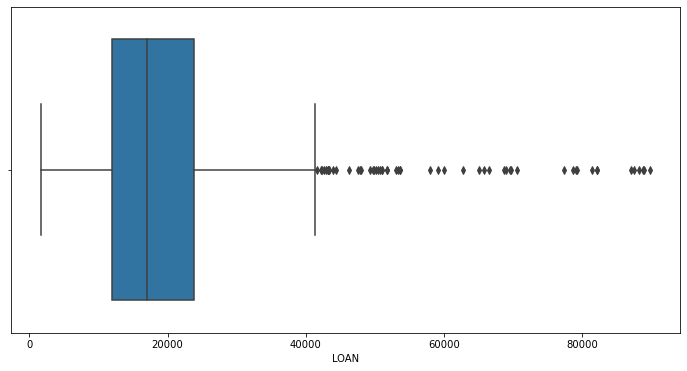

In [11]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(x=df_debtinc_filtered["LOAN"]);

#### Decidimos eliminar los outliers que están por encima del percentil 0.95.

In [12]:
quantile_95 = df_debtinc_filtered["LOAN"].quantile(0.95)
quantile_95

36344.999999999985

In [13]:
df_filtered = df_debtinc_filtered[df_debtinc_filtered["LOAN"] < quantile_95]
df_filtered

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1826,1,32000,33148.0,69965.0,13.0,2.0,4.0,112.510865,3.0,27.0,36.021509
1827,1,33100,111917.0,156552.0,12.0,0.0,0.0,107.294900,2.0,37.0,41.441549
1828,1,33200,36705.0,78040.0,19.0,2.0,0.0,120.090143,0.0,13.0,35.015749
1830,1,34600,169960.0,224716.0,2.0,0.0,0.0,182.068461,2.0,21.0,32.710205


### Decidimos visualizar los outliers de la columna MORTDUE a través de un boxplot.

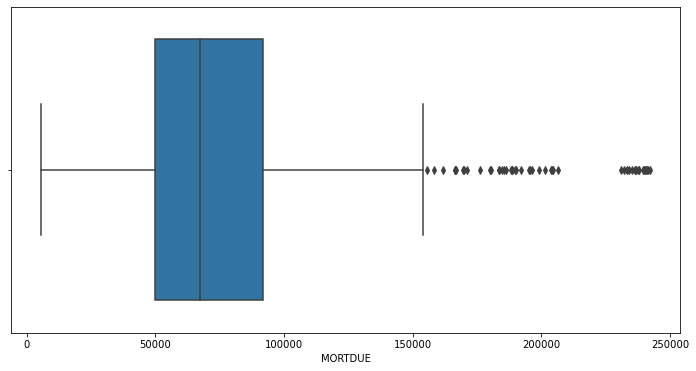

In [14]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(x=df_filtered["MORTDUE"]);

#### Decidimos eliminar los outliers que están por encima del percentil 0.95.

In [15]:
quantile_95 = df_filtered["MORTDUE"].quantile(0.95)
quantile_95

145762.55

In [16]:
df_filtered = df_filtered[df_filtered["MORTDUE"] < quantile_95]
df_filtered

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1820,1,28700,25190.0,59841.0,1.0,0.0,1.0,201.176783,0.0,11.0,35.729287
1825,1,31200,38352.0,80550.0,21.0,1.0,0.0,116.437908,0.0,14.0,35.381863
1826,1,32000,33148.0,69965.0,13.0,2.0,4.0,112.510865,3.0,27.0,36.021509
1827,1,33100,111917.0,156552.0,12.0,0.0,0.0,107.294900,2.0,37.0,41.441549


In [17]:
print(f"Se eliminó el siguiente porcentaje del total de registros: {round(100 - (1508 * 100 / 1854), 2)}%.")

Se eliminó el siguiente porcentaje del total de registros: 18.66%.


In [18]:
#histplot_graficos(df_filtered, columns_list)

## División en entrenamiento y evaluación

In [19]:
# División entre instancias y etiquetas
X, y = df.iloc[:, 1:], df.TARGET

### Aplicamos un escalamiento estándar al conjunto de datos.

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [21]:
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

---

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

#### __RESPUESTAS__

__¿De qué se trata el conjunto de datos?__  
Es un conjunto de datos parcial que contiene datos de cada formulario de solicitud que rellenan los solicitantes de prestamos hipotecarios realizado por la empresa Dream Housing Finance, con el objetivo de determinar, mediante la automatizacion de un proceso, la elegibilidad de cada clientes solicitante del prestamo.

__¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?__  
La variable objetivo a predecir es la elegibilidad del cliente para un prestamos hipotecario. Esto implica el uso de informacion recopilada en la encuesta para determinar la idoneidad y confiabilidad de los solicitantes de los prestamos hipotecarios.

__¿Qué información (atributos) hay disponible para hacer la predicción?__  
Para realizar la prediccion disponemos de la informacion aportada por los clientes en el formulario de solicitud de prestamo. Esta informacion esta de forma parcial, contenida en un data set de Kaggle. Contiene las siguientes columnas:
'Loan_ID', 'Gender', 'Married', 'Dependents', 'Education','Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'.

__¿Qué atributos imagina ud. que son los más determinantes para la predicción?__  
Para el analisis de la elegibilidad del cliente para un prestamo hipotecario los atributos mas determinantes son:
'Credit_History','LoanAmount','Self_Employed','ApplicantIncome'.

---

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión (por defecto?) de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

## SGDClassifier con hiperparámetros por defecto, donde el tipo de modelo es Linear SVM

#### Fijamos la semilla aleatoria en un valor igual a 5.

In [22]:
rint = 5

#### Instanciamos la clase SGDClassifier.

In [23]:
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000, random_state=rint)

#### Entrenamos el modelo.

In [24]:
clf.fit(X_train, y_train)

SGDClassifier(max_iter=10000, random_state=5)

### Generamos el conjunto de valores predichos a partir del conjunto de entrenamiento.

In [25]:
y_train_pred = clf.predict(X_train)

#### Mostramos los valores del conjunto TARGET de entrenamiento y los del conjunto de predicciones.

In [26]:
np.set_printoptions(threshold=np.inf)
print(f'⦁ y_train: cantidad de valores = {y_train.size}\n\n{np.array(y_train)}\n')
print('---'*25)
print(f'\n⦁ y_train_pred: cantidad de valores = {y_train_pred.size}\n\n{y_train_pred}\n')

⦁ y_train: cantidad de valores = 1483

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 

#### Comparación de los valores reales frente a los valores predichos en un dataframe.

In [27]:
df = pd.DataFrame(data=y_train_pred, columns=['y_train_pred'])
df['y_train'] = np.array(y_train)
df = df[['y_train', 'y_train_pred']]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas.")

⦁ El dataframe de comparación cuenta con un total de 1483 filas y 2 columnas.


#### Muestra del dataframe de comparación.

In [28]:
rows_size = 24 # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")

,y_train,y_train_pred
0,0,0
1,0,1
2,0,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


#### Métricas

In [29]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, zero_division=1)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
confusion_matrix_values = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}  ")

⦁ accuracy = 0.8469318948078219
⦁ precision = 0.5545454545454546
⦁ recall = 0.4860557768924303
⦁ f1 = 0.5180467091295116
⦁ confusion_matrix_values = TN: 1134, FP: 98, FN: 129, TP: 122
[[1134   98]
 [ 129  122]]  


### A

In [30]:
data = {
    "type_of_set": "train",
    "hiperparameters": "default",
    "loss": "hinge", 
    "penalty": "l2",
    "alpha": "",
    "learning_rate": "",
    "eta0": "",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}
results_df = pd.DataFrame(data, index=[0])
results_df

,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047


### Generamos el conjunto de valores predichos a partir del conjunto de test.

In [31]:
y_test_pred = clf.predict(X_test)

#### Mostramos los valores del conjunto TARGET de test y los del conjunto de predicciones.

In [32]:
np.set_printoptions(threshold=np.inf)
print(f'⦁ y_test: cantidad de valores = {y_test.size}\n\n{np.array(y_test)}\n')
print('---'*25)
print(f'\n⦁ y_test_pred: cantidad de valores = {y_test_pred.size}\n\n{y_test_pred}\n')

⦁ y_test: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_test_pred: cantidad de valores = 371

[0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1

### Comparación de los valores reales frente a los valores predichos en un dataframe.

In [33]:
df = pd.DataFrame(data=y_test_pred, columns=['y_test_pred'])
df['y_test'] = np.array(y_test)
df = df[['y_test', 'y_test_pred']]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas.")

⦁ El dataframe de comparación cuenta con un total de 371 filas y 2 columnas.


#### Muestra del dataframe de comparación.

In [34]:
rows_size = 24 # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")

,y_test,y_test_pred
0,0,0
1,0,1
2,0,0
3,1,1
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,0,0


## Métricas

In [35]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=1)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_matrix_values = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}  ")

⦁ accuracy = 0.8490566037735849
⦁ precision = 0.52
⦁ recall = 0.4482758620689655
⦁ f1 = 0.48148148148148145
⦁ confusion_matrix_values = TN: 289, FP: 24, FN: 32, TP: 26
[[289  24]
 [ 32  26]]  


In [36]:
data = {
    "type_of_set": "test",
    "hiperparameters": "default",
    "loss": "hinge", 
    "penalty": "l2",
    "alpha": "",
    "learning_rate": "",
    "eta0": "",
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df

,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481


### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de:  
- loss  
- tasas de entrenamiento (learning_rate)  
- tasas de regularización

Para ello, usar **grid-search** y **5-fold cross-validation** sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar **accuracy**, **promedio** y **varianza** para todas las configuraciones.

Para la **mejor configuración** encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

## Solución

#### Generamos un diccionario con distintos valores para los hiperparámetros:
- "loss": función de costo asociada a un tipo de modelo en particular.
- "alpha": coeficiente del término de regularización.
- "learning_rate": tipo de tasa de aprendizaje.
- "eta0": valor inicial de la tasa de aprendizaje.

In [37]:
param_dist = {
    "loss": [
        "hinge",        # SVM
        "log",          # logistic regression
        "perceptron"    # perceptron   
    ],
    "alpha": loguniform(1e-4, 1e2),  # de 0.0001 a 100.0
    "learning_rate": [
        "constant",
        "optimal",
        #"invscaling"
    ],
    "eta0": uniform(
        low=0, high=100, size=30
    ) # The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules. Values must be in the range (0.0, inf).
}

#### Por medio de la clase RandomizedSearchCV, empleamos una grilla de parámetros para generar distintas combinaciones de valores de hiperparámetros aleatoriamente, y aplicamos validación cruzada.

- La cantidad inicial de combinaciones a formar de los valores de los hiperparámetros es 30.
- La semilla aleatoria es la misma que antes: 5.

In [38]:
combinations_size = 30 # Setear la cantidad total de combinaciones a crear de los valores de los hiperparámetros.
model = SGDClassifier(random_state=rint)
cv = RandomizedSearchCV(
    model, 
    param_dist, 
    n_iter=combinations_size, 
    cv=5, 
    random_state=rint
)

#### Entrenamos el modelo.

In [39]:
cv.fit(X_train, y_train);

#### Cargamos los resultados del entrenamiento en un dataframe, y realizamos una vista previa del mismo, donde se incluyen los valores de la media y la varianza de cada configuración.

In [40]:
results = cv.cv_results_
df = pd.DataFrame(results)
interesting_columns = [
    'param_loss', 
    'param_alpha', 
    'param_learning_rate', 
    'param_eta0',
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
]
df[interesting_columns].sort_values(by="rank_test_score").reset_index(drop=True)

,param_loss,param_alpha,param_learning_rate,param_eta0,mean_test_score,std_test_score,rank_test_score
0,log,0.001482,optimal,67.146392,0.869858,0.008694,1
1,hinge,0.000203,optimal,50.470544,0.859080,0.017454,2
2,hinge,0.000305,optimal,16.673361,0.857053,0.015277,3
3,log,0.083143,optimal,88.031726,0.855025,0.003608,4
4,hinge,0.2394,optimal,67.146392,0.846262,0.003859,5
5,hinge,0.397718,optimal,83.203277,0.839515,0.003433,6
6,perceptron,0.000244,optimal,16.673361,0.832815,0.040011,7
7,log,0.250097,constant,35.807682,0.830749,0.001259,8
8,log,18.510512,optimal,93.042466,0.830749,0.001259,8
9,log,34.395188,constant,33.414652,0.830749,0.001259,8


#### Capturamos el mejor estimador, es decir aquella combinación de valores de hiperparámetros que mejoran las métricas de las predicciones.

In [41]:
best_estimator = cv.best_estimator_
best_estimator

SGDClassifier(alpha=0.001481787510127265, eta0=67.14639229564895, loss='log',
              random_state=5)

In [42]:
new_params = cv.best_params_
loss = new_params['loss']
alpha = new_params['alpha']
learning_rate = new_params['learning_rate']
eta0 = new_params['eta0']

print("Los nuevos valores de los hiperparámetros son:")
print(f"⦁ loss = {loss}")
print(f"⦁ alpha = {alpha}")
print(f"⦁ learning_rate = {learning_rate}")
print(f"⦁ eta0 = {eta0}")

Los nuevos valores de los hiperparámetros son:
⦁ loss = log
⦁ alpha = 0.001481787510127265
⦁ learning_rate = optimal
⦁ eta0 = 67.14639229564895


## SGDClassifier con hiperparámetros modificados

#### Fijamos la semilla aleatoria en un valor igual a 5.

In [43]:
rint = 5

#### Instanciamos la clase SGDClassifier con los mejores valores encontrados de los hiperparámetros.

In [44]:
clf = SGDClassifier(
    loss=loss,
    alpha=alpha,
    learning_rate=learning_rate,
    eta0=eta0,
    penalty='l2', 
    max_iter=1000, 
    random_state=rint
)

#### Entrenamos el modelo.

In [45]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001481787510127265, eta0=67.14639229564895, loss='log',
              random_state=5)

### Generamos el conjunto de valores predichos a partir del conjunto de entrenamiento.

In [46]:
y_train_pred = clf.predict(X_train)

#### Mostramos los valores del conjunto TARGET de entrenamiento y los del conjunto de predicciones.

In [47]:
np.set_printoptions(threshold=np.inf)
print(f'⦁ y_train: cantidad de valores = {y_train.size}\n\n{np.array(y_train)}\n')
print('---'*25)
print(f'\n⦁ y_train_pred: cantidad de valores = {y_train_pred.size}\n\n{y_train_pred}\n')

⦁ y_train: cantidad de valores = 1483

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1
 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 

#### Comparación de los valores reales frente a los valores predichos en un dataframe.

In [48]:
df = pd.DataFrame(data=y_train_pred, columns=['y_train_pred'])
df['y_train'] = np.array(y_train)
df = df[['y_train', 'y_train_pred']]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas.")

⦁ El dataframe de comparación cuenta con un total de 1483 filas y 2 columnas.


#### Muestra del dataframe de comparación.

In [49]:
rows_size = 24 # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")

,y_train,y_train_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


#### Métricas

In [50]:
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, zero_division=1)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
confusion_matrix_values = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}  ")

⦁ accuracy = 0.8718813216453135
⦁ precision = 0.7850467289719626
⦁ recall = 0.3346613545816733
⦁ f1 = 0.4692737430167598
⦁ confusion_matrix_values = TN: 1209, FP: 23, FN: 167, TP: 84
[[1209   23]
 [ 167   84]]  


In [51]:
data = {
    "type_of_set": "train",
    "hiperparameters": "modified",
    "loss": loss, 
    "penalty": "l2",
    "alpha": alpha,
    "learning_rate": learning_rate,
    "eta0": eta0,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df

,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
2,train,modified,log,l2,0.001482,optimal,67.146392,0.871881,0.785047,0.334661,0.469274


### Generamos el conjunto de valores predichos a partir del conjunto de test.

In [52]:
y_test_pred = clf.predict(X_test)

#### Mostramos los valores del conjunto TARGET de test y los del conjunto de predicciones.

In [53]:
np.set_printoptions(threshold=np.inf)
print(f'⦁ y_test: cantidad de valores = {y_test.size}\n\n{np.array(y_test)}\n')
print('---'*25)
print(f'\n⦁ y_test_pred: cantidad de valores = {y_test_pred.size}\n\n{y_test_pred}\n')

⦁ y_test: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 1]

---------------------------------------------------------------------------

⦁ y_test_pred: cantidad de valores = 371

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0

### Comparación de los valores reales frente a los valores predichos en un dataframe.

In [54]:
df = pd.DataFrame(data=y_test_pred, columns=['y_test_pred'])
df['y_test'] = np.array(y_test)
df = df[['y_test', 'y_test_pred']]
df_data = df.shape
rows = df_data[0]
cols = df_data[1]
print(f"⦁ El dataframe de comparación cuenta con un total de {rows} filas y {cols} columnas.")

⦁ El dataframe de comparación cuenta con un total de 371 filas y 2 columnas.


#### Muestra del dataframe de comparación.

In [55]:
rows_size = 24 # Setear el número de filas a mostrar.
df.iloc[:rows_size].style.background_gradient(cmap="Blues")

,y_test,y_test_pred
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Métricas

In [56]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=1)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
confusion_matrix_values = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print(f"⦁ accuracy = {accuracy}")
print(f"⦁ precision = {precision}")
print(f"⦁ recall = {recall}")
print(f"⦁ f1 = {f1}")
print(f"⦁ confusion_matrix_values = TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}\n{confusion_matrix_values}  ")

⦁ accuracy = 0.8706199460916442
⦁ precision = 0.7272727272727273
⦁ recall = 0.27586206896551724
⦁ f1 = 0.4
⦁ confusion_matrix_values = TN: 307, FP: 6, FN: 42, TP: 16
[[307   6]
 [ 42  16]]  


In [57]:
data = {
    "type_of_set": "test",
    "hiperparameters": "modified",
    "loss": loss, 
    "penalty": "l2",
    "alpha": alpha,
    "learning_rate": learning_rate,
    "eta0": eta0,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}
aux_df = pd.DataFrame(data, index=[0])
results_df = pd.concat([results_df, aux_df], ignore_index=True)
results_df

,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
2,train,modified,log,l2,0.001482,optimal,67.146392,0.871881,0.785047,0.334661,0.469274
3,test,modified,log,l2,0.001482,optimal,67.146392,0.870620,0.727273,0.275862,0.400000


In [58]:
results_df = results_df.sort_values(by="type_of_set", ascending=False)
results_df = results_df.reset_index(drop=True)

In [59]:
results_df

,type_of_set,hiperparameters,loss,penalty,alpha,learning_rate,eta0,accuracy,precision,recall,f1
0,train,default,hinge,l2,,,,0.846932,0.554545,0.486056,0.518047
1,train,modified,log,l2,0.001482,optimal,67.146392,0.871881,0.785047,0.334661,0.469274
2,test,default,hinge,l2,,,,0.849057,0.520000,0.448276,0.481481
3,test,modified,log,l2,0.001482,optimal,67.146392,0.870620,0.727273,0.275862,0.400000


#### Observamos que al modificar los hiperparámetros el accuracy del modelo respecto del conjunto de entrenamiento aumentó en un 2.49%, y el accuracy respecto del conjunto de test creció en un 2.16%. En ambos conjuntos, la función de costo elegida para mejorar las métricas fue la regresión logística.

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Definición del modelo utilizando la clase DecisionTreeClassifier, utilizando los valores de parámetros por defecto. Luego realizamos el entrenamiento del modelo.

---

In [64]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=None, random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

Realizamos la predicción tanto para el conjunto de datos de entrenamiento, como para el de validación.

In [65]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [66]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 1.0
Test accuracy: 0.89


In [63]:
from utils_custom import plot_decision_boundary

plot_decision_boundary(lambda x: clf.predict(x), X_train, y_train)

ValueError: X has 2 features, but DecisionTreeClassifier is expecting 10 features as input.

Inspeccionamos el arbol de desición

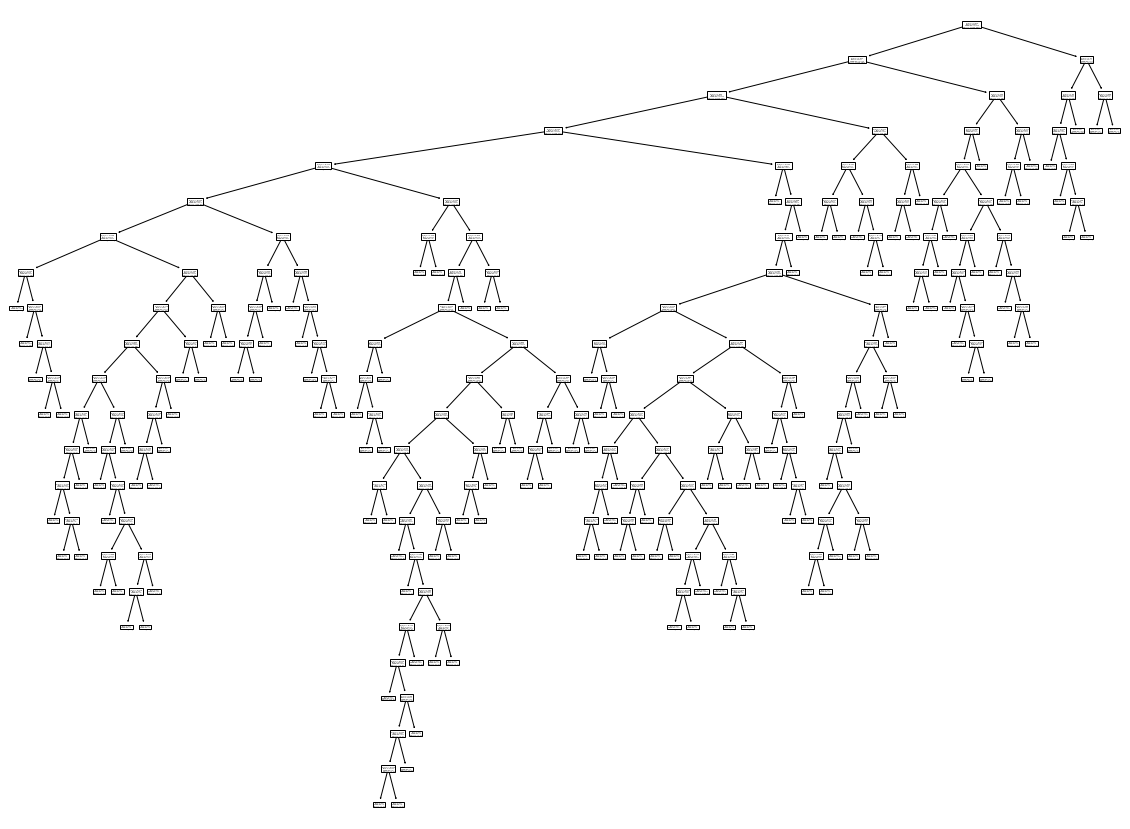

In [67]:
from sklearn.tree import plot_tree

plot_tree(clf);

In [68]:
#Función que calcula la probabilidad
def probs(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return probs

In [69]:
#Función que calcula la entropía
def entropy(y):
    p = probs(y)
    return - np.sum(p * np.log2(p))

Calculamos la entropía de nuestro conjunto de entrenamiento

In [70]:
print(f'Entropía: {entropy(y_train):0.2}')

Entropía: 0.66


Observamos el reporte de clasificación sobre el conjunto de de entrenmiento y sobre el de validación.

In [71]:
from sklearn.metrics import classification_report
print("Reporte sobre el conjunto de entrenamiento")
print(classification_report(y_train, y_train_pred))

Reporte sobre el conjunto de entrenamiento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



In [72]:
from sklearn.metrics import classification_report
print("Reporte sobre el conjunto de validación")
print(classification_report(y_test, y_test_pred))

Reporte sobre el conjunto de validación
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       313
           1       0.63      0.67      0.65        58

    accuracy                           0.89       371
   macro avg       0.78      0.80      0.79       371
weighted avg       0.89      0.89      0.89       371



Analizamos la matriz de confusion

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[290,  23],
       [ 19,  39]], dtype=int64)

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')

True Negative: 290
False Positive: 23
False Negative: 19
True Positive: 39


c:\Users\Diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


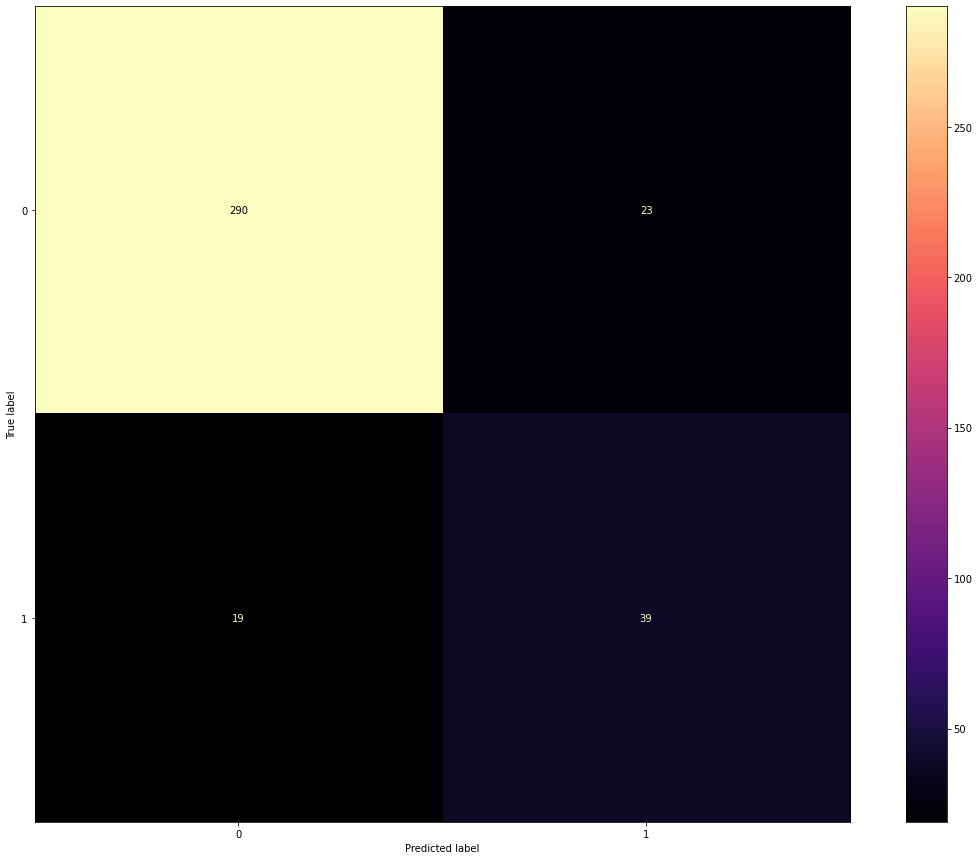

In [75]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, cmap='magma')  

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo:  
- __criterion__: probar diferentes criterios de partición  
- __max_depth__: profundidad máxima del árbol    
- __min_samples_leaf__: cantidad mínima de samples por hoja

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

---

A continuación vamos a definir el diccionario con los hiperparámetros y los valores de estos parámetros, con los cuales vamos a realizar todas las combinaciones posibles durante la validación cruzada.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier??

In [76]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf' : [2, 4, 6],
    'random_state' : [0, 2, 4],
}

Analizaremos todas las combinaciones posibles de los parametros declarados en el diccionario param_grid.

In [ ]:
from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
    print(params)
    model = DecisionTreeClassifier(**params)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 6, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 0}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 2}
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'random_state': 4}
{'criterion': 'gini', 'max_depth': 4, 'm

A continuación utilizaremos la función GridSearchCV, para realizar la validación cruzada sobre la lista de parámetros declarada anteriormente. Utilizando el método de división estratificada en 5 (default value) subconjuntos partiendo del conjunto de entrenamiento. La división estratificada mantiene en la subdivisiones la misma proporción de clases que existen en nuestro dataset original. De esta manera, obtendremos una grilla con los resultados basados en la accuracy para todas las conbinaciones posibles de nuestros parámetros.

In [77]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [78]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")

crit.	depth	| mean	std	rank
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	2	| 0.87	0.01	47
gini	4	| 0.88	0.02	23
gini	4	| 0.88	0.02	26
gini	4	| 0.88	0.02	17
gini	4	| 0.88	0.01	6
gini	4	| 0.88	0.02	16
gini	4	| 0.88	0.01	10
gini	4	| 0.88	0.01	6
gini	4	| 0.88	0.01	10
gini	4	| 0.88	0.01	10
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	13
gini	6	| 0.88	0.01	31
gini	6	| 0.88	0.01	27
gini	6	| 0.88	0.01	18
gini	6	| 0.88	0.02	13
gini	6	| 0.88	0.02	8
gini	6	| 0.88	0.02	8
gini	8	| 0.88	0.02	25
gini	8	| 0.87	0.02	35
gini	8	| 0.88	0.02	30
gini	8	| 0.87	0.03	37
gini	8	| 0.87	0.02	39
gini	8	| 0.87	0.02	41
gini	8	| 0.88	0.03	21
gini	8	| 0.88	0.03	21
gini	8	| 0.88	0.03	15
gini	10	| 0.88	0.02	2
gini	10	| 0.88	0.02	24
gini	10	| 0.89	0.01	1
gini	10	| 0.88	0.02	3
gini	10	| 0.88	0.03	29
gini	10	| 0.88	0.02	4
gini	10	| 0.88	0.03	19
gini	10	| 0.88	0.03	19
gini

In [81]:
import pandas as pd
df = pd.DataFrame(results)
df = df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]
#df
df = df.sort_values(by="rank_test_score")
df

,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
38,gini,10,0.885374,0.013945,1
36,gini,10,0.882676,0.019574,2
39,gini,10,0.881343,0.022609,3
41,gini,10,0.881338,0.019380,4
44,gini,10,0.879318,0.032216,5
...,...,...,...,...,...
85,entropy,10,0.860431,0.015915,86
86,entropy,10,0.859084,0.015874,87
89,entropy,10,0.855044,0.027269,88
88,entropy,10,0.853021,0.028055,89


A través de la función, vamos a explorar el mejor modelo y parámetros obtenidos a través de la validación cruzada.

In [82]:
cv.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'random_state': 4}

Exploramos el mejor modelo encontrado

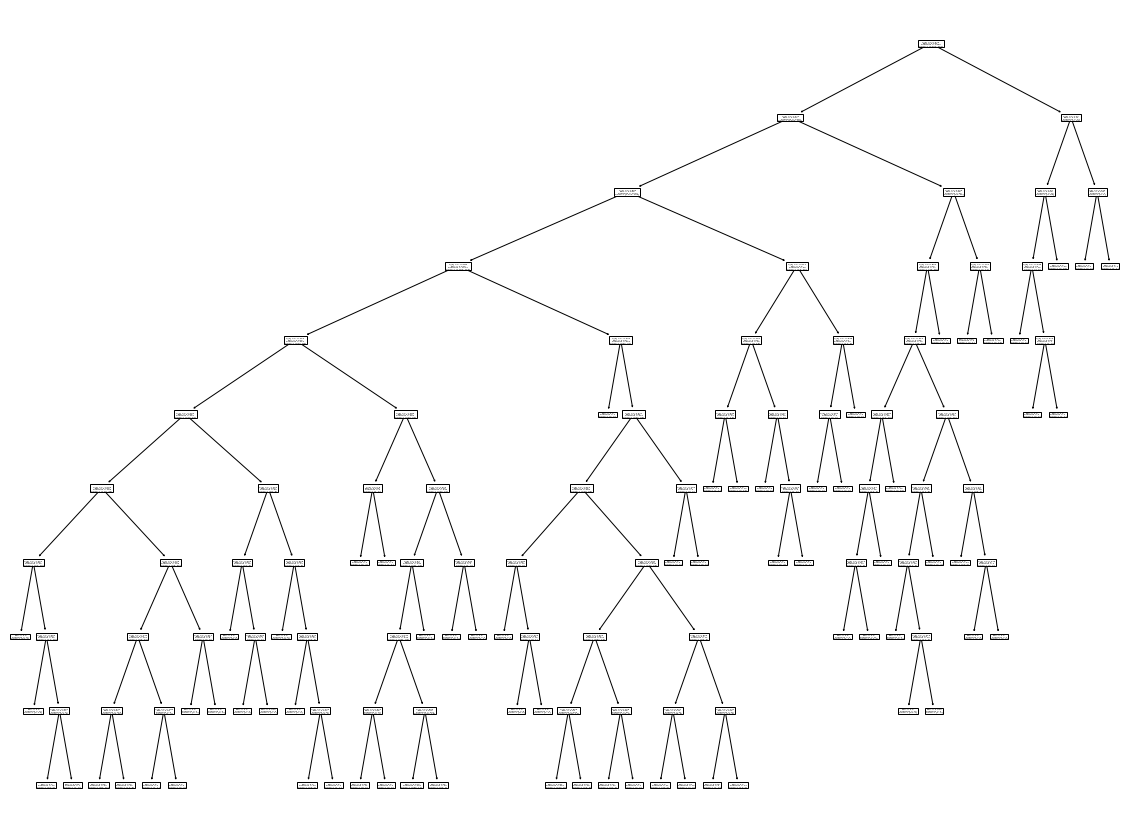

In [83]:
from sklearn.tree import plot_tree
best_model = cv.best_estimator_
plot_tree(best_model);

Ahora vamos a predecir con el mejor modelo encontrado sobre el conjunto de entrenamiento y evaluación

In [84]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f'Train accuracy: {train_acc:0.2}')
print(f'Test accuracy: {test_acc:0.2}')

Train accuracy: 0.95
Test accuracy: 0.91


Analizamos las métricas para el conjunto de datos de entrenamiento 

In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1232
           1       0.98      0.72      0.83       251

    accuracy                           0.95      1483
   macro avg       0.96      0.86      0.90      1483
weighted avg       0.95      0.95      0.95      1483



Analizamos las métricas para el conjunto de datos de evaluación

In [87]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       313
           1       0.80      0.55      0.65        58

    accuracy                           0.91       371
   macro avg       0.86      0.76      0.80       371
weighted avg       0.90      0.91      0.90       371



Matriz de confusion

In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)


array([[1229,    3],
       [  70,  181]], dtype=int64)

In [89]:
confusion_matrix(y_test, y_test_pred)

array([[305,   8],
       [ 26,  32]], dtype=int64)

In [90]:
#cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred, labels=[0, 1]).ravel()

print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')


True Negative: 305
False Positive: 8
False Negative: 26
True Positive: 32


Graficamos la matriz de confusion

c:\Users\Diego\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


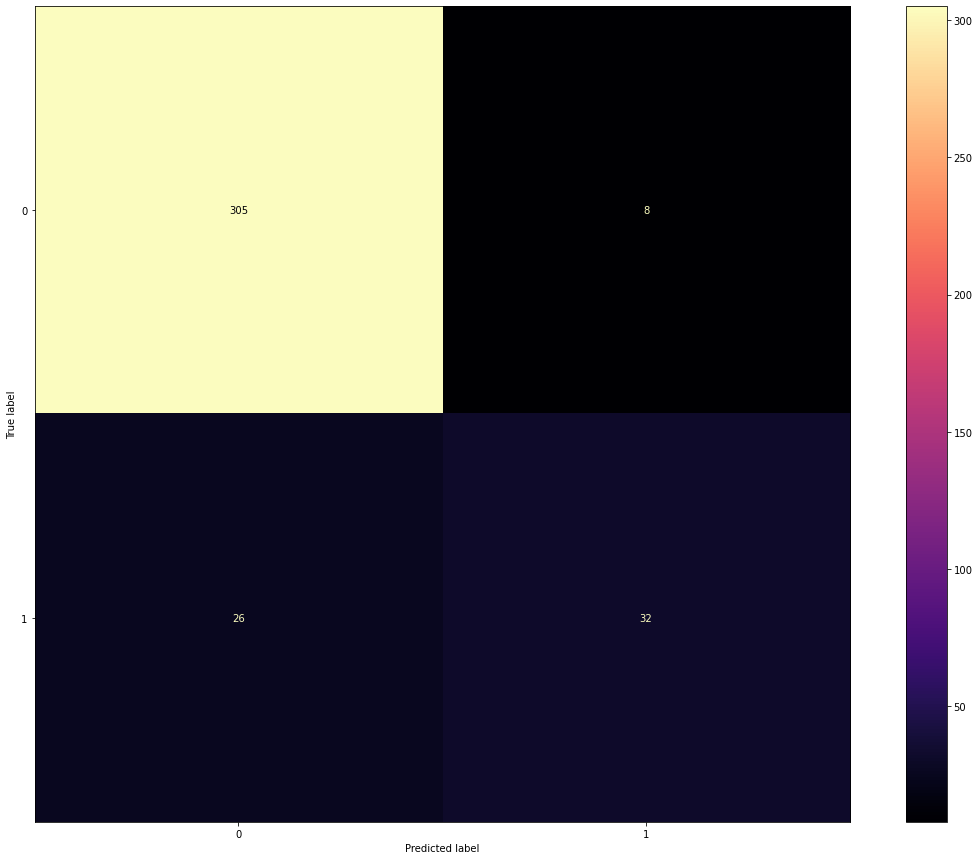

In [91]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_model, X_test, y_test, cmap='magma')  
